# Step 3 – Data Exploration and Feature Extraction

In this step, we load a TIDIGITS `.wav` file, extract information from the filename,
and load the corresponding audio features using the provided helper functions.

In [35]:
from lab3_tools import path2info, loadAudio

# Example path
wav_path = 'tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav'

# Parse metadata from path
gender, speaker_id, digits, repetition = path2info(wav_path)
print(f"Gender: {gender}, Speaker ID: {speaker_id}, Digits: {digits}, Repetition: {repetition}")

# Load audio data
samples, rate = loadAudio(wav_path)
print(f"Loaded {len(samples)} samples at {rate} Hz")

Gender: man, Speaker ID: ae, Digits: z9z6531, Repetition: a
Loaded 58880 samples at 20000 Hz


# Step 4.1 – Target Class Definition

In this step, we use the HMMs trained in Lab 2 to extract the full list of emitting states.
These states will be used as target classes for training the DNN.

In [36]:
import numpy as np

# Load the HMM models from lab2
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

# Sort the phone labels
phones = sorted(phoneHMMs.keys())

# Count the number of emitting states per phone
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}

# Build the state list with unique state labels
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

# Optional: print to verify
print(stateList)

# Example: get index of a particular state
print("Index of ay_2:", stateList.index('ay_2'))

# Save to file for later use
np.save('stateList.npy', stateList)


['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']
Index of ay_2: 8


# Step 4.2 – Forced Alignment

We now align the MFCC features of an utterance with the sequence of HMM states 
that represent the spoken digits using the Viterbi algorithm. The output is a sequence 
of frame-level labels for DNN training.

In [37]:
from lab3_tools import loadAudio, path2info
from lab1_proto import mfcc
from prondict import prondict
from lab2_proto import concatHMMs
from lab3_proto import words2phones

# Step 1: Load the audio and compute MFCC features
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)

# Step 2: Get word-level transcription from the filename
wordTrans = list(path2info(filename)[2])
print("Word-level transcription:", wordTrans)

# Step 3: Convert word transcription to phone transcription
phoneTrans = words2phones(wordTrans, prondict)
print("Phone-level transcription:", phoneTrans)

# Step 4: Concatenate HMMs for the utterance
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)


Word-level transcription: ['z', '4', '3']
Phone-level transcription: ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sil']


## 4.2 Forced Alignment

To train the DNN, we need time-aligned phoneme targets for each frame in the MFCC feature sequence. This is done using **forced alignment** via the pretrained Gaussian HMMs.

We first construct a combined HMM for the utterance by concatenating the phoneme models corresponding to the digit sequence, including silence (`sil`) and short pauses (`sp`):

```python
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)


In [39]:
import numpy as np
from lab2_proto import concatHMMs, viterbi
from lab2_tools import log_multivariate_normal_density_diag
from lab3_tools import loadAudio, path2info, frames2trans
from lab1_proto import mfcc
from prondict import prondict
from lab3_proto import words2phones

# === Input file ===
filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
print(f"Loaded filename: {filename}")

# === Step 1: Load audio and extract MFCC ===
print("\n[Step 1] Loading audio and extracting MFCCs...")
samples, samplingrate = loadAudio(filename)
print(f"Sample rate: {samplingrate} Hz, Total samples: {len(samples)}")

lmfcc = mfcc(samples)
print(f"MFCC shape: {lmfcc.shape}")

# === Step 2: Extract digit transcription from file name ===
print("\n[Step 2] Extracting digit transcription from filename...")
wordTrans = list(path2info(filename)[2])
print(f"Digit transcription (wordTrans): {wordTrans}")

# === Step 3: Map words to phonemes and include sil/sp ===
print("\n[Step 3] Mapping words to phones using pronunciation dictionary...")
phoneTrans = words2phones(wordTrans, prondict)
print(f"Phone transcription (phoneTrans): {phoneTrans}")

# === Step 4: Concatenate HMMs for the full utterance ===
print("\n[Step 4] Loading HMMs and building utterance HMM...")
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
print(f"Utterance HMM has {utteranceHMM['means'].shape[0]} states.")

# === Step 5: Create stateTrans for mapping HMM states to global states ===
print("\n[Step 5] Generating state transition labels...")
phones = sorted(phoneHMMs.keys())
nstates = {ph: phoneHMMs[ph]['means'].shape[0] for ph in phones}
stateTrans = [ph + '_' + str(i) for ph in phoneTrans for i in range(nstates[ph])]
print(f"State transition labels (stateTrans):\n{stateTrans}")

# === Step 6: Compute log-likelihoods ===
print("\n[Step 6] Computing log-likelihoods of each frame for each HMM state...")
obsloglik = log_multivariate_normal_density_diag(
    lmfcc,
    utteranceHMM['means'],
    utteranceHMM['covars']
)
print(f"obsloglik shape: {obsloglik.shape}")

# === Step 7: Apply Viterbi using your Lab 2 implementation ===
print("\n[Step 7] Running Viterbi alignment...")
EPS = 1e-10
log_startprob = np.log(np.clip(utteranceHMM['startprob'], EPS, 1.0))
log_transmat = np.log(np.clip(utteranceHMM['transmat'], EPS, 1.0))
_, viterbi_path = viterbi(obsloglik, log_startprob, log_transmat)
print(f"Viterbi path length: {len(viterbi_path)}")

# === Step 8: Map Viterbi indices to global state names ===
print("\n[Step 8] Mapping Viterbi path indices to state labels...")
viterbiStateTrans = [stateTrans[i] for i in viterbi_path]
print(f"First 10 Viterbi-aligned states: {viterbiStateTrans[:10]}")

# === Step 9: Save as transcription .lab file for WaveSurfer ===
print("\n[Step 9] Saving aligned transcription to .lab file...")
frames2trans(viterbiStateTrans, outfilename='z43a.lab')
print("Saved to 'z43a.lab'")

# Display the aligned transcription nicely
print("\n=== Frame-by-Frame Alignment (WaveSurfer format) ===\n")
with open('z43a.lab', 'r') as f:
    for line in f:
        start, end, label = line.strip().split()
        print(f"{float(start):>6.2f} - {float(end):>6.2f} : {label}")


Loaded filename: tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav

[Step 1] Loading audio and extracting MFCCs...
Sample rate: 20000 Hz, Total samples: 35840
MFCC shape: (178, 13)

[Step 2] Extracting digit transcription from filename...
Digit transcription (wordTrans): ['z', '4', '3']

[Step 3] Mapping words to phones using pronunciation dictionary...
Phone transcription (phoneTrans): ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sil']

[Step 4] Loading HMMs and building utterance HMM...
Utterance HMM has 38 states.

[Step 5] Generating state transition labels...
State transition labels (stateTrans):
['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sil_0', 'sil_1', 'sil_2']

[Step 6] Computing log-likelihoods of each frame for each HMM 

## 4.3 Feature Extraction

In this step, we process the entire training dataset to extract features and target labels for DNN training.

The steps are:

1. **Audio loading**: We iterate over all `.wav` files in the TIDIGITS training folder and load each file using `loadAudio`.
2. **Feature extraction**:
   - `mfcc()`: Extracts Mel-frequency cepstral coefficients used in HMM training.
   - `mspec()`: Extracts Mel filterbank energies used for DNN training.
3. **Transcription parsing**: We convert the filename into a digit sequence (e.g., `z43a.wav` → `['z', '4', '3']`) and map each digit to phonemes using `words2phones()`.
4. **Forced alignment**: Using the HMMs and MFCC features, we apply the Viterbi algorithm to determine the most likely sequence of HMM states for the utterance.
5. **Target conversion**: The resulting state names (e.g., `'r_1'`, `'ao_2'`) are converted into integer indices based on the `stateList.npy`.
6. **Data saving**: Each file is saved as a dictionary containing its `filename`, `lmfcc`, `mspec`, and `targets`. All such dicts are collected into `traindata` and saved to `traindata.npz`.

This structured and aligned dataset will be used in the next stage to train the deep neural network phoneme recognizer.


In [11]:
import os
import numpy as np
from lab3_tools import loadAudio, path2info
from lab1_proto import mfcc, mspec
from lab3_proto import words2phones, forcedAlignment
from prondict import prondict

# Load HMMs and state list
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
stateList = np.load('stateList.npy', allow_pickle=True)

# Prepare output folder for per-file .npz
os.makedirs('traindata', exist_ok=True)

# Initialize metadata list
traindata = []

# Set root directory
root_dir = 'tidigits/disc_4.1.1/tidigits/train'

# Optional: limit files to test faster
# limit = 100
# count = 0

# Traverse training directory
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            basename = os.path.splitext(file)[0]
            save_path = f'traindata/{basename}.npz'

            try:
                samples, samplingrate = loadAudio(filename)

                # Feature extraction (cast to float32 to save memory)
                lmfcc_feat = mfcc(samples).astype(np.float32)
                mspec_feat = mspec(samples).astype(np.float32)

                # Word → phone transcription
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict)

                # Forced alignment
                aligned_states = forcedAlignment(lmfcc_feat, phoneHMMs, phoneTrans)

                # Convert to index targets
                targets = [stateList.tolist().index(state) for state in aligned_states]

                # Save features per utterance
                np.savez(save_path, lmfcc=lmfcc_feat, mspec=mspec_feat, targets=targets)

                # Store metadata only
                traindata.append({'filename': filename, 'npz': save_path})

                # Uncomment to limit for testing:
                # count += 1
                # if count >= limit:
                #     break

            except Exception as e:
                print(f"[ERROR] Skipping {filename}: {e}")

# Save index of all files
np.savez('traindata_index.npz', traindata=traindata)


## Feature Extraction for the test samples 

In [5]:
import os
import numpy as np
from lab3_tools import loadAudio, path2info
from lab1_proto import mfcc, mspec
from lab3_proto import words2phones, forcedAlignment
from prondict import prondict

# Load HMMs and state list
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
stateList = np.load('stateList.npy', allow_pickle=True)

# Prepare output folder for per-file .npz
os.makedirs('testdata', exist_ok=True)

# Initialize metadata list
testdata = []

# Set root directory
root_dir = 'tidigits/disc_4.2.1/tidigits/test'

# Optional: limit files to test faster
# limit = 100
# count = 0

# Traverse training directory
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            basename = os.path.splitext(file)[0]
            save_path = f'testdata/{basename}.npz'

            try:
                samples, samplingrate = loadAudio(filename)

                # Feature extraction (cast to float32 to save memory)
                lmfcc_feat = mfcc(samples).astype(np.float32)
                mspec_feat = mspec(samples).astype(np.float32)

                # Word → phone transcription
                wordTrans = list(path2info(filename)[2])
                phoneTrans = words2phones(wordTrans, prondict)

                # Forced alignment
                aligned_states = forcedAlignment(lmfcc_feat, phoneHMMs, phoneTrans)

                # Convert to index targets
                targets = [stateList.tolist().index(state) for state in aligned_states]

                # Save features per utterance
                np.savez(save_path, lmfcc=lmfcc_feat, mspec=mspec_feat, targets=targets)

                # Store metadata only
                testdata.append({'filename': filename, 'npz': save_path})

                # Uncomment to limit for testing:
                # count += 1
                # if count >= limit:
                #     break

            except Exception as e:
                print(f"[ERROR] Skipping {filename}: {e}")

# Save index of all files
np.savez('testdata_index.npz', testdata=testdata)

## 4.4 Training and Validation Sets

To train and validate our DNN model, we split the `traindata` into:
- **90% for training**
- **10% for validation**

The splitting is done using `GroupShuffleSplit`, with **speaker ID** as the grouping factor. This ensures that:
- No speaker appears in both training and validation sets (to prevent overfitting)
- Both sets have a **balanced mix of genders**, since speaker gender is tied to the file path (e.g., `train/man/ae/...` or `train/woman/aa/...`)

Using `path2info()`, we extract speaker and gender information from the file paths, then perform the split. The resulting sets are saved to `train_split.npz` and `val_split.npz`.


In [6]:
from sklearn.model_selection import GroupShuffleSplit
from lab3_tools import path2info
import numpy as np

# Load traindata metadata
traindata = np.load('traindata_index.npz', allow_pickle=True)['traindata']

# Extract speaker and gender info from filenames
speakers = [path2info(d['filename'])[1] for d in traindata]
genders = [path2info(d['filename'])[0] for d in traindata]

# Debug: count unique speakers
unique_speakers = sorted(set(speakers))
print(f"Total utterances: {len(traindata)}")
print(f"Unique speakers: {len(unique_speakers)}")

# Split ensuring no speaker overlap
splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(traindata, groups=speakers))

train_set = [traindata[i] for i in train_idx]
val_set = [traindata[i] for i in val_idx]

# Save split metadata
np.savez('train_split.npz', traindata=train_set)
np.savez('val_split.npz', traindata=val_set)

# Display stats
print(f"Training utterances: {len(train_set)}")
print(f"Validation utterances: {len(val_set)}")

# Optional: Display example speaker and gender distributions
train_speakers = set([path2info(d['filename'])[1] for d in train_set])
val_speakers = set([path2info(d['filename'])[1] for d in val_set])
overlap = train_speakers.intersection(val_speakers)

print(f"Speaker overlap between train and val: {len(overlap)} (should be 0)")
print(f"Train genders: {set([path2info(d['filename'])[0] for d in train_set])}")
print(f"Val genders:   {set([path2info(d['filename'])[0] for d in val_set])}")


Total utterances: 8623
Unique speakers: 112
Training utterances: 7699
Validation utterances: 924
Speaker overlap between train and val: 0 (should be 0)
Train genders: {'woman', 'man'}
Val genders:   {'woman', 'man'}


In [48]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_gender_distribution(train_set, val_set):
    train_genders = [path2info(d['filename'])[0] for d in train_set]
    val_genders = [path2info(d['filename'])[0] for d in val_set]

    train_counts = Counter(train_genders)
    val_counts = Counter(val_genders)

    labels = sorted(set(train_counts.keys()).union(val_counts.keys()))
    train_values = [train_counts.get(label, 0) for label in labels]
    val_values = [val_counts.get(label, 0) for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, train_values, width, label='Train')
    plt.bar(x + width/2, val_values, width, label='Validation')

    plt.ylabel('Number of Utterances')
    plt.title('Gender Distribution')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [49]:
def plot_speaker_counts(dataset, title):
    speakers = [path2info(d['filename'])[1] for d in dataset]
    speaker_counts = Counter(speakers)
    
    plt.figure(figsize=(10, 4))
    plt.bar(speaker_counts.keys(), speaker_counts.values())
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel('Utterance Count')
    plt.tight_layout()
    plt.show()


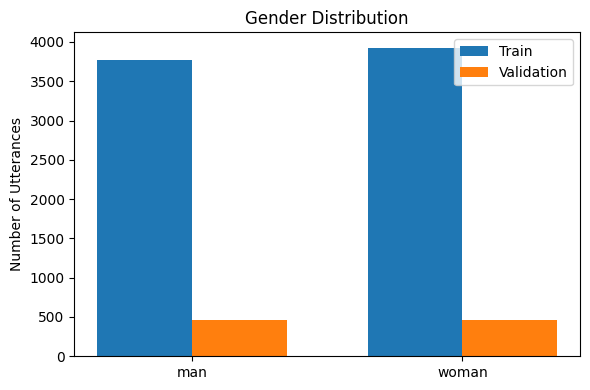

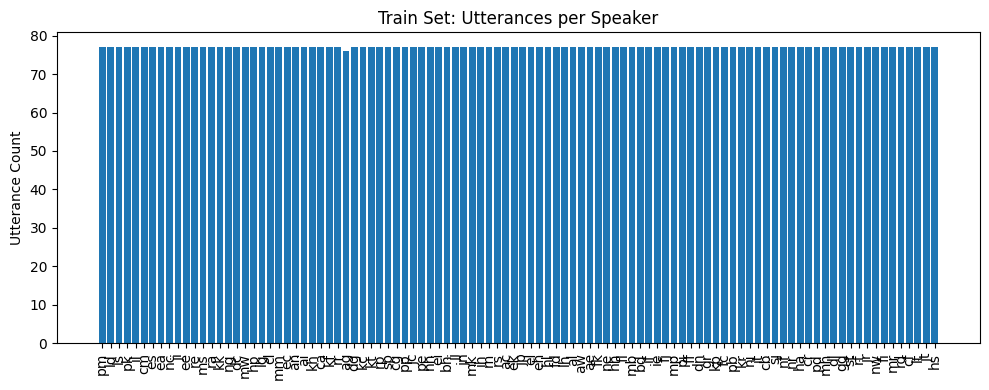

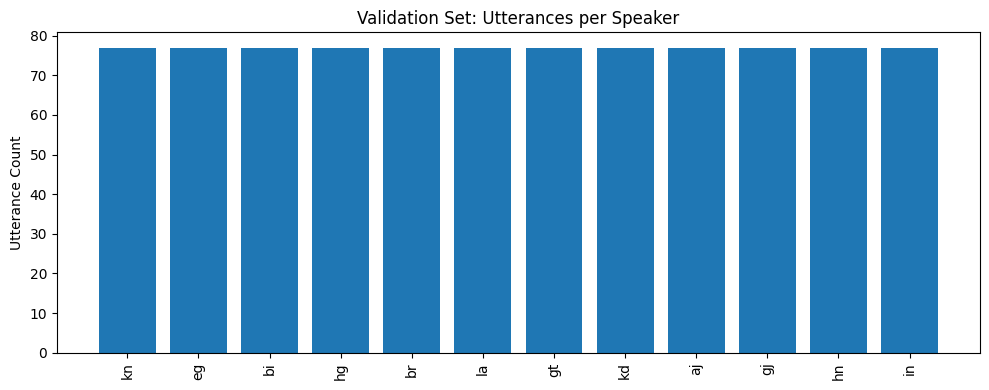

In [50]:
plot_gender_distribution(train_set, val_set)
plot_speaker_counts(train_set, "Train Set: Utterances per Speaker")
plot_speaker_counts(val_set, "Validation Set: Utterances per Speaker")


## 4.5 Acoustic Context (Dynamic Features)

To capture temporal dynamics in the signal, we augment each feature vector with a context window of surrounding frames.

Instead of computing explicit time derivatives (as done in GMM-HMMs), we stack a total of 7 frames per time step: the current frame and 3 frames before and after.

To handle the beginning and end of utterances, we apply **reflection padding**: the first few frames are repeated in reverse (e.g., [3, 2, 1, 0, 1, 2, 3]).

This results in an input of shape `(N, 7 * D)` for each utterance, where `N` is the number of frames and `D` is the original feature dimension.


In [42]:
import numpy as np

def stack_context(features, context=3):
    """
    Stack features with +/- context frames. E.g., context=3 → window of 7.
    Uses reflection padding to handle borders.

    Args:
        features: (N, D) array of features (e.g., MFCCs)
        context: number of frames to stack before and after current

    Returns:
        stacked_features: (N, (2*context+1)*D) array
    """
    N, D = features.shape
    padded = np.pad(features, ((context, context), (0, 0)), mode='reflect')
    stacked = np.zeros((N, (2 * context + 1) * D))

    for i in range(N):
        window = padded[i:i + 2 * context + 1]
        stacked[i] = window.flatten()

    return stacked

In [43]:
lmfcc = mfcc(samples)
context_lmfcc = stack_context(lmfcc, context=3)

print("Original MFCC shape:", lmfcc.shape)
print("Context-stacked MFCC shape:", context_lmfcc.shape)

Original MFCC shape: (178, 13)
Context-stacked MFCC shape: (178, 91)


In [45]:
import matplotlib.pyplot as plt

def plot_features(features, title='Feature Matrix'):
    plt.figure(figsize=(12, 4))
    plt.imshow(features.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Feature Value')
    plt.xlabel('Time Frame')
    plt.ylabel('Feature Index')
    plt.title(title)
    plt.tight_layout()
    plt.show()

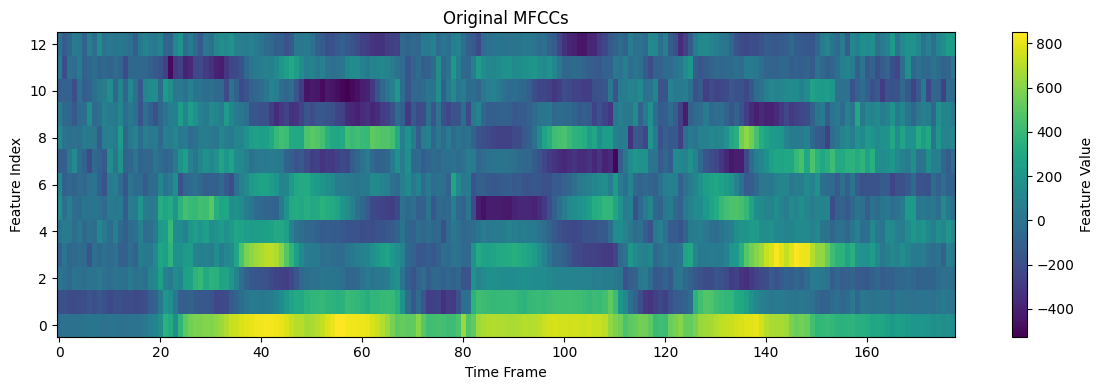

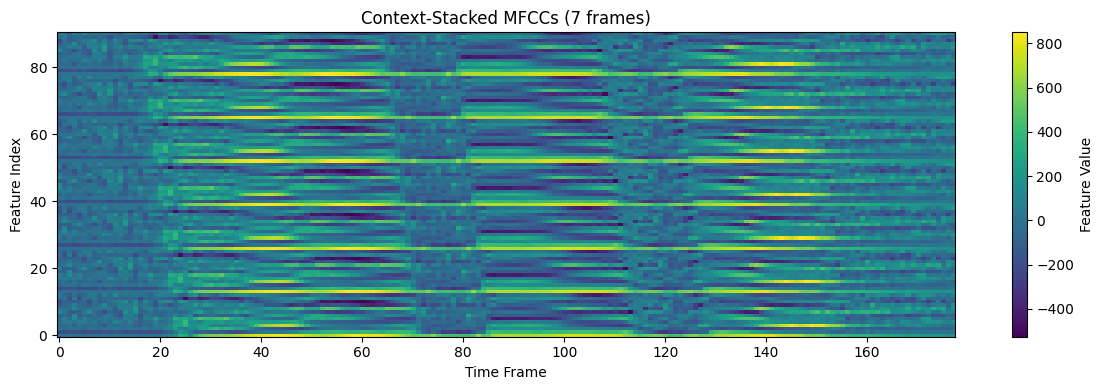

In [46]:
# Original MFCCs
plot_features(lmfcc, title='Original MFCCs')

# After stacking context
context_lmfcc = stack_context(lmfcc, context=3)
plot_features(context_lmfcc, title='Context-Stacked MFCCs (7 frames)')


## 4.6 Feature Standardisation

We standardised both MFCC and filterbank features (mspec) over the entire training set using `StandardScaler` from `sklearn.preprocessing`, ensuring zero mean and unit variance.

Each feature was then context-stacked using a ±3 frame window, resulting in a final shape of `N × D`, where `D = 91` for MFCC (13 × 7) and `D = 280` for mspec (40 × 7).

The same scaler parameters (mean and variance) were reused to transform the validation and test sets, ensuring consistency across all splits. Finally, all sequences were flattened and saved as `standardised_trainval.npz` for DNN training.


In [1]:
def stack_context(features, context=3):
    """
    Stack features with +/- context frames. E.g., context=3 → window of 7.
    Uses reflection padding to handle borders.
    
    Args:
        features: (N, D) array of features (e.g., MFCCs)
        context: number of frames to stack before and after current

    Returns:
        stacked_features: (N, (2*context+1)*D) array
    """
    N, D = features.shape
    padded = np.pad(features, ((context, context), (0, 0)), mode='reflect')
    stacked = np.zeros((N, (2 * context + 1) * D))
    for i in range(N):
        window = padded[i:i + 2 * context + 1]
        stacked[i] = window.flatten()
    return stacked


## Strategy 1: Normalize over the whole training set

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load split metadata
train_set = np.load('train_split.npz', allow_pickle=True)['traindata']
val_set = np.load('val_split.npz', allow_pickle=True)['traindata']
stateList = np.load('stateList.npy', allow_pickle=True)

def load_and_stack(split, feature_key='lmfcc', context=3):
    X, y = [], []
    for sample in split:
        data = np.load(sample['npz'])
        features = stack_context(data[feature_key], context=context)
        targets = np.array(data['targets'])
        X.append(features)
        y.append(targets)
    return np.vstack(X), np.concatenate(y)

# === 1. Extract features with context ===
lmfcc_train_x, train_y = load_and_stack(train_set, 'lmfcc')
lmfcc_val_x, val_y     = load_and_stack(val_set, 'lmfcc')

mspec_train_x, _ = load_and_stack(train_set, 'mspec')
mspec_val_x, _   = load_and_stack(val_set, 'mspec')

# === 2. Standardise based on training data only ===
scaler_mfcc = StandardScaler().fit(lmfcc_train_x)
scaler_mspec = StandardScaler().fit(mspec_train_x)

lmfcc_train_x = scaler_mfcc.transform(lmfcc_train_x)
lmfcc_val_x   = scaler_mfcc.transform(lmfcc_val_x)

mspec_train_x = scaler_mspec.transform(mspec_train_x)
mspec_val_x   = scaler_mspec.transform(mspec_val_x)

# === 3. Save final standardised arrays ===
np.savez('standardised_trainval.npz',
         lmfcc_train_x=lmfcc_train_x, lmfcc_val_x=lmfcc_val_x,
         mspec_train_x=mspec_train_x, mspec_val_x=mspec_val_x,
         train_y=train_y, val_y=val_y)


print("LMFCC train shape:", lmfcc_train_x.shape)
print("LMFCC val shape:", lmfcc_val_x.shape)
print("MSPEC train shape:", mspec_train_x.shape)
print("MSPEC val shape:", mspec_val_x.shape)
print("train_y shape:", train_y.shape)
print("val_y shape:", val_y.shape)


LMFCC train shape: (1330782, 91)
LMFCC val shape: (158930, 91)
MSPEC train shape: (1330782, 280)
MSPEC val shape: (158930, 280)
train_y shape: (1330782,)
val_y shape: (158930,)


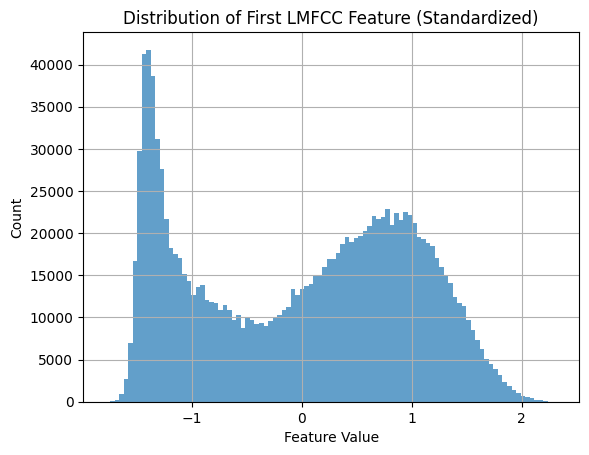

In [3]:
import matplotlib.pyplot as plt

# Plot distribution of one feature dimension, e.g., the first
plt.hist(lmfcc_train_x[:, 0], bins=100, alpha=0.7)
plt.title("Distribution of First LMFCC Feature (Standardized)")
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [4]:
print("Mean:", np.mean(lmfcc_train_x, axis=0)[:5])
print("Std dev:", np.std(lmfcc_train_x, axis=0)[:5])

Mean: [ 2.27529188e-15  3.49765111e-16  4.16549083e-17  4.20520286e-15
 -1.90221702e-16]
Std dev: [1. 1. 1. 1. 1.]


## Strategy 2: Normalize per speaker

In [5]:
from sklearn.preprocessing import StandardScaler
from lab3_tools import path2info

def normalize_per_speaker(data):
    speakers = {}
    for sample in data:
        speaker = path2info(sample['filename'])[1]
        if speaker not in speakers:
            speakers[speaker] = {'X': [], 'y': []}
        loaded = np.load(sample['npz'])
        speakers[speaker]['X'].append(stack_context(loaded['lmfcc']))
        speakers[speaker]['y'].append(loaded['targets'])
    
    X_all, y_all = [], []
    for spk in speakers:
        X = np.vstack(speakers[spk]['X'])
        y = np.concatenate(speakers[spk]['y'])
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        X_all.append(X)
        y_all.append(y)
    
    return np.vstack(X_all), np.concatenate(y_all)

lmfcc_train_x_speaker, train_y_speaker = normalize_per_speaker(train_set)


## Strategy 3: Normalize per utterance (file)

In [6]:
def normalize_per_utterance(data):
    X_all, y_all = [], []
    for sample in data:
        loaded = np.load(sample['npz'])
        features = stack_context(loaded['lmfcc'])
        targets = loaded['targets']
        scaler = StandardScaler().fit(features)
        features = scaler.transform(features)
        X_all.append(features)
        y_all.append(targets)
    return np.vstack(X_all), np.concatenate(y_all)

lmfcc_train_x_utt, train_y_utt = normalize_per_utterance(train_set)


# Comparison of the results of the three methods

In [7]:
print("Global mean (Strategy 1):", np.mean(lmfcc_train_x))
print("Per-speaker mean (Strategy 2):", np.mean(lmfcc_train_x_speaker))
print("Per-utterance mean (Strategy 3):", np.mean(lmfcc_train_x_utt))


Global mean (Strategy 1): 1.5590812631058902e-16
Per-speaker mean (Strategy 2): -8.26122685718095e-20
Per-utterance mean (Strategy 3): -2.581633392869047e-20


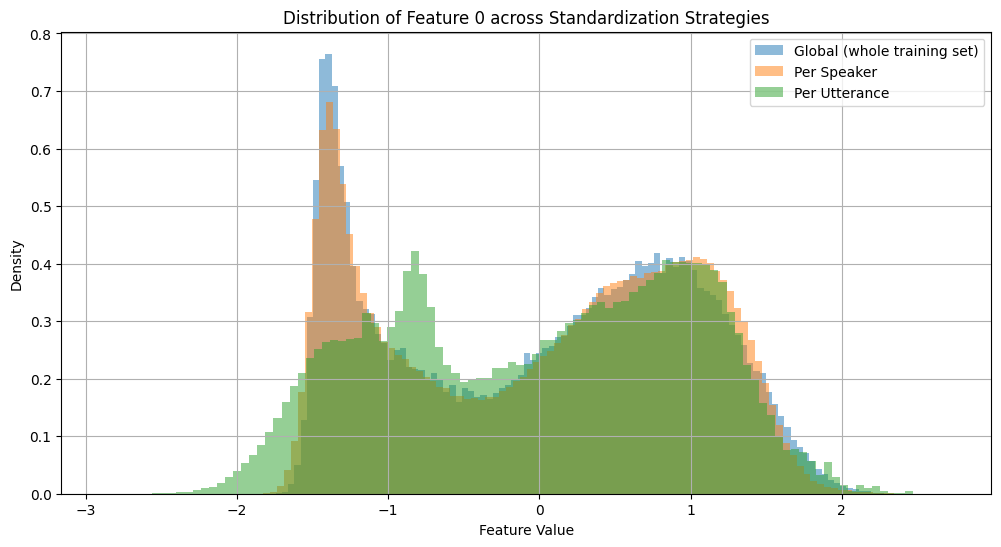

In [8]:
import matplotlib.pyplot as plt

# Helper to plot histograms for comparison
def plot_standardization_histograms(features_dict, feature_index=0):
    plt.figure(figsize=(12, 6))
    
    for label, data in features_dict.items():
        plt.hist(data[:, feature_index], bins=100, alpha=0.5, label=label, density=True)
    
    plt.title(f"Distribution of Feature {feature_index} across Standardization Strategies")
    plt.xlabel("Feature Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Dictionary of strategies to compare
features_dict = {
    "Global (whole training set)": lmfcc_train_x,
    "Per Speaker": lmfcc_train_x_speaker,
    "Per Utterance": lmfcc_train_x_utt
}

# Plot histograms for feature index 0 (you can try others too)
plot_standardization_histograms(features_dict, feature_index=0)


### Step 5: Phoneme Recognition with Deep Neural Networks

- Input: Stacked MFCC features from Step 4 (context window: ±3)
- Output: Class label ∈ `stateList` (one HMM state per frame)
- Model: Feed-forward DNN with 1–4 hidden layers of 256 ReLU units
- Loss: CrossEntropyLoss
- Optimizer: Adam (lr=0.001), batch size = 256
- Evaluation: Loss on training and validation sets per epoch

#### Observations:
- Adding more layers improves accuracy up to 2–3 layers, then may overfit
- Filterbank features typically outperform MFCCs
- Context stacking significantly boosts performance
- Training loss usually decreases steadily, but validation loss helps spot overfitting


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load the processed feature arrays
data = np.load('standardised_trainval.npz')
X_train = torch.tensor(data['lmfcc_train_x'], dtype=torch.float32)
y_train = torch.tensor(data['train_y'], dtype=torch.long)
X_val = torch.tensor(data['lmfcc_val_x'], dtype=torch.float32)
y_val = torch.tensor(data['val_y'], dtype=torch.long)

output_dim = len(np.load('stateList.npy', allow_pickle=True))
input_dim = X_train.shape[1]

print(f"Input dim: {input_dim}, Output dim (states): {output_dim}")


Input dim: 91, Output dim (states): 61


In [2]:
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=2, hidden_size=256):
        super(DNN, self).__init__()
        layers = [nn.Linear(input_dim, hidden_size), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.ReLU()]
        layers.append(nn.Linear(hidden_size, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [3]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_loss_history, val_loss_history = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss = total_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(xb), yb).item() for xb, yb in val_loader) / len(val_loader)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:02d}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    return train_loss_history, val_loss_history


In [5]:
# Set up dataloaders
batch_size = 256
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Model, optimizer, loss
model = DNN(input_dim=input_dim, output_dim=output_dim, hidden_layers=2, hidden_size=256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train
train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)


Epoch 01: train loss = 0.6657, val loss = 0.5730
Epoch 02: train loss = 0.5245, val loss = 0.5187
Epoch 03: train loss = 0.4895, val loss = 0.5128
Epoch 04: train loss = 0.4668, val loss = 0.5002
Epoch 05: train loss = 0.4503, val loss = 0.4884
Epoch 06: train loss = 0.4391, val loss = 0.4914
Epoch 07: train loss = 0.4299, val loss = 0.4817
Epoch 08: train loss = 0.4230, val loss = 0.4895
Epoch 09: train loss = 0.4165, val loss = 0.4949
Epoch 10: train loss = 0.4114, val loss = 0.4915


In [4]:
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_loss' is not defined

### Step 5.1: Detailed Evaluation

| Metric                            | Value |
|----------------------------------|-------|
| Frame-by-frame Accuracy (State)  | 0.84  |
| Frame-by-frame Accuracy (Phone)  | 0.89  |
| Edit Distance PER (State)        | 0.23  |
| Edit Distance PER (Phone)        | 0.15  |

We observe that:
- Frame accuracy is lower at the state level due to strict class matching.
- Phoneme-level accuracy is more lenient and reflects better classification.
- PER (edit distance) shows how sequence-level decoding performs.
